In [14]:
# Setup
# allow interaction with the plots
%matplotlib widget

%load_ext autoreload
%autoreload 2

# add the main directory reference and import 'imports.py'
import sys

if ".." not in sys.path:
    sys.path.insert(0, "..")
from imports import *

logging.basicConfig(level=logging.ERROR)
__builtins__.verbosity = 5


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Declare a few global data/train params
class params:
    batch_size = 16
    num_workers = 4

    max_epochs = 40
    lr = 0.005

    n_blks = 2
    hidden_size = 128
    dropout = 0.1
    activation = "relu"


In [4]:
from data.CellViability import *


dt = CellViability(DataConfig.create(params))
cdt = CellViabilityClassification(DataConfig.create(params))

dt.preview(samples=1)
cdt.preview(samples=1)

# not training well but data looks fine
# for v in [x[1] for x in iter(cdt.loaders()[1])]:
#     print(v)


data[-1] counts in label order from 0:
N: 132
Y: 392

Train Data (30 batches) Preview:
--------------------------------------------------
Constituent shapes:
batch[0]: torch.Size([16, 39]), torch.float32
batch[1]: torch.Size([16]), torch.float32

First 1 samples:

Sample 0: 

tensor([5.0000e+00, 2.2000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+02, 1.5000e+02, 0.0000e+00, 0.0000e+00, 6.0000e+02, 1.2000e+03,
        1.5298e+02, 4.1000e+02, 8.4000e+02, 4.0000e+06, 2.8000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00])

98.62999725341797

Validation Data (4 batches)  Preview:
--------------------------------------------------

Sample 0: 

tensor([1.0000e+01, 1.0000e+01, 8.0000e+00, 2.0000e+01, 0.0000e+00, 0.0000e+

In [15]:
# define metrics and eval

import torcheval.metrics as ms
from lib.train import *


def init_cmetrics(flush_every, train=False):
    classification_val = MetricsFrame(
        [
            from_te(ms.BinaryAccuracy, "Accuracy"),
            from_te(ms.BinaryPrecision, "Precision"),
            from_te(ms.BinaryRecall, "Recall"),
        ],
        flush_every=flush_every,
    )

    if train:
        classification_train = MetricsFrame(
            [
                from_te(ms.BinaryAccuracy, "Accuracy"),
                from_te(ms.BinaryPrecision, "Precision"),
                from_te(ms.BinaryRecall, "Recall"),
            ],
            flush_every=flush_every,
        )

        cval_board = ProgressBoard(ylabel="Percent", title="Metrics (Validation)")
        cval_board.add_mf(classification_val)

        ctrain_board = ProgressBoard(
            ylabel="Percent", title="Metrics (Train)", train_prefix=""
        )
        ctrain_board.add_mf(classification_train)

        return {"train_mfs": [classification_train], "val_mfs": [classification_val]}
    return {"val_mfs": [classification_val]}


def eval_cmodel(trainer, **kwargs):
    eval_ms = MetricsFrame(
        [
            from_te(
                ms.BinaryConfusionMatrix,
                "ConfusionMatrix",
            ),
            from_te(
                ms.BinaryAccuracy,
                "Accuracy",
            ),
        ],
        flush_every=0,
        xlabel=None,
    )

    out = trainer.eval(pred=True, loss=True, mfs=eval_ms, **kwargs)
    plot_2dheatmap(eval_ms.dict["ConfusionMatrix"][0], close_last=False)
    print(eval_ms.dict["Accuracy"][0])
    return eval_ms.dict["Accuracy"][0], out


def eval_model(trainer: Trainer, **kwargs):
    out = trainer.eval(pred=True, loss=True, **kwargs)
    loss_arr = out["loss"][0][0]
    return sum(loss_arr) / len(loss_arr), out


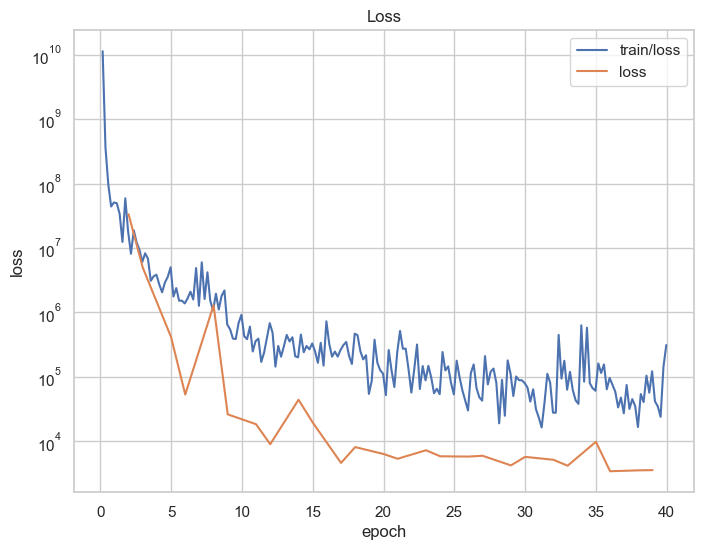

Epochs progress:   0%|          | 0/40 [00:00<?, ?Epoch/s]

tensor(457.4925, device='cuda:0')

In [ ]:
# train default regression model

from models.MLP import *

default_model = MLP(MLPConfig.create(params))

default_trainer = Trainer(TrainerConfig.create(params))
default_trainer.fit(default_model, dt.loaders())


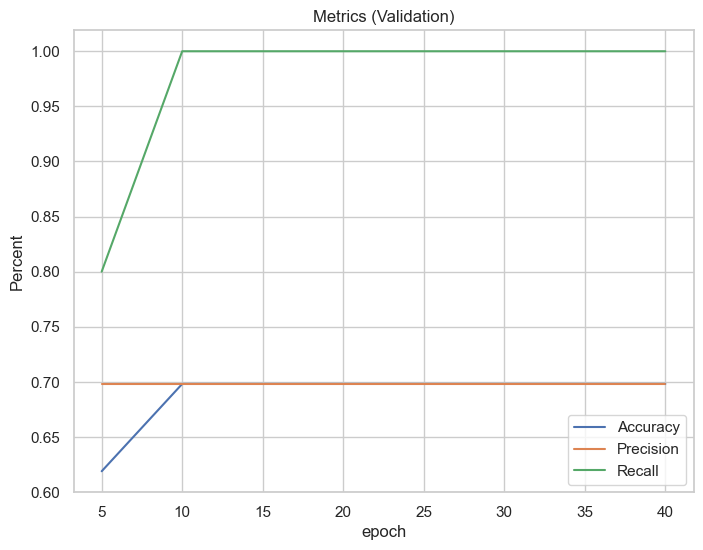

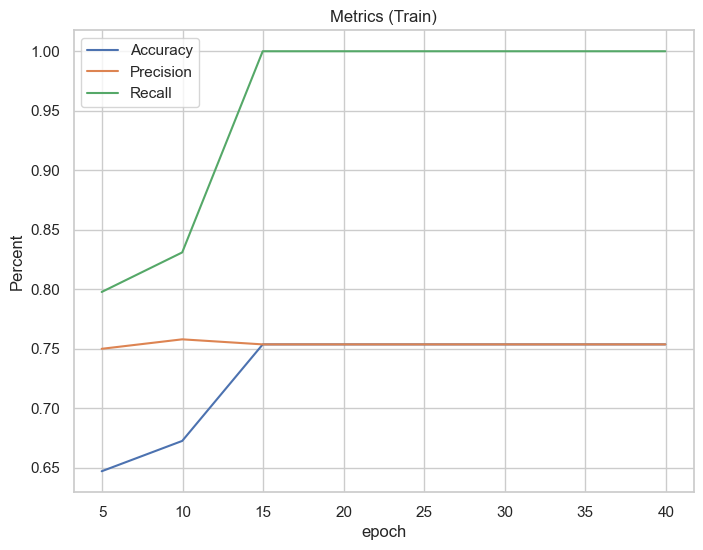

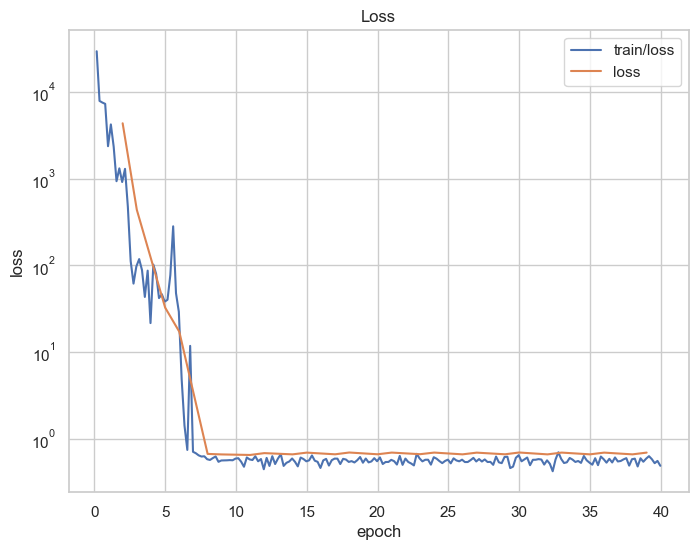

Epochs progress [Loss: 9.001e-02]: 100%|██████████| 40/40 [00:22<00:00,  1.81Epoch/s]


NameError: name 'default_trainer' is not defined

In [ ]:
# train default classification model

from models.MLP import *

default_cmodel = MLPClassifier(MLPConfig.create(params, n_classes=cdt.classes))
default_ctrainer = Trainer(TrainerConfig.create(params, **init_cmetrics(5, train=True)))
default_ctrainer.fit(default_cmodel, cdt.loaders())


0it [00:00, ?it/s]

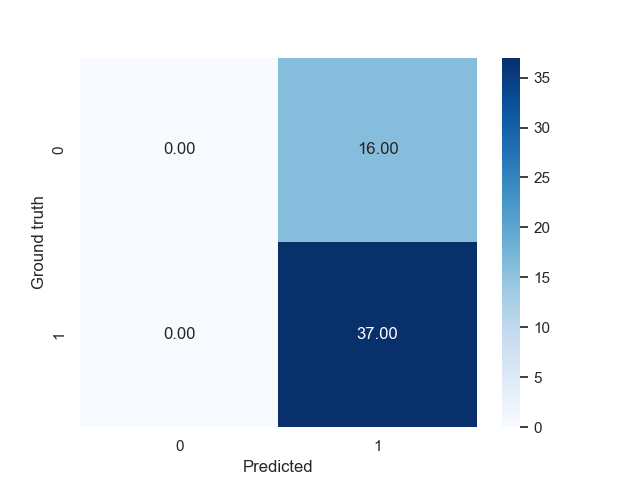

[0.698113203048706]


{'pred': [(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         dtype=float32),),
  (array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         dtype=float32),),
  (array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         dtype=float32),),
  (array([1., 1., 1., 1., 1.], dtype=float32),)],
 'loss': [(array([0.83121914], dtype=float32),),
  (array([0.42796978], dtype=float32),),
  (array([0.49517798], dtype=float32),),
  (array([0.9387523], dtype=float32),)],
 'batch_num': [0, 1, 2, 3]}

In [14]:
# Evaluate model
# print(cmodel)
# for p in cmodel.named_parameters():
#     print(p)
eval_cmodel(default_ctrainer)

In [18]:
# grid search over parameters
class grid_params:
    activation = (
        "relu",
        "sigmoid",
        "tanh",
    )
    lr = [0.0001, 0.005, 0.01]
    momentum = [True, False]
    dropout = [0.05, 0.3, 0.6]
    test_dropout = [None, 0.5, 0.8]
    betas = [(0.9, 0.999), (0.0, 0.999)]


######
Iterating over activation: ('relu', 'sigmoid', 'tanh')
#####



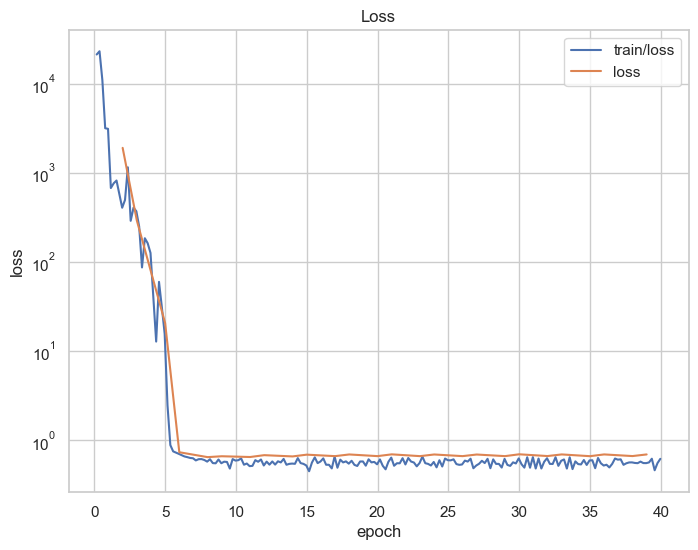

Epochs progress [Loss: 9.042e-02]: 100%|██████████| 40/40 [00:12<00:00,  3.25Epoch/s]


0it [00:00, ?it/s]

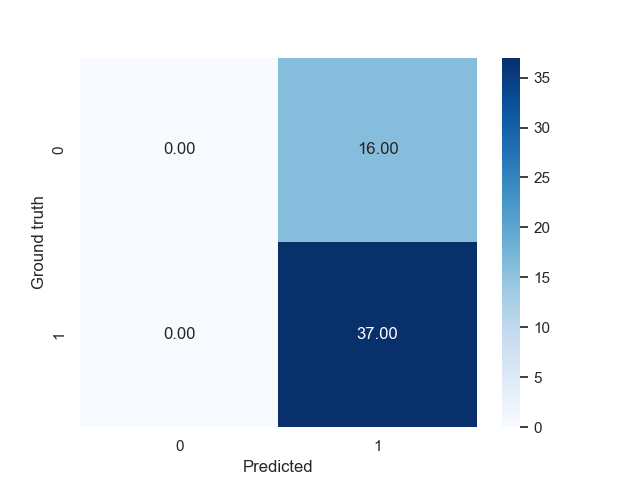

0.698113203048706


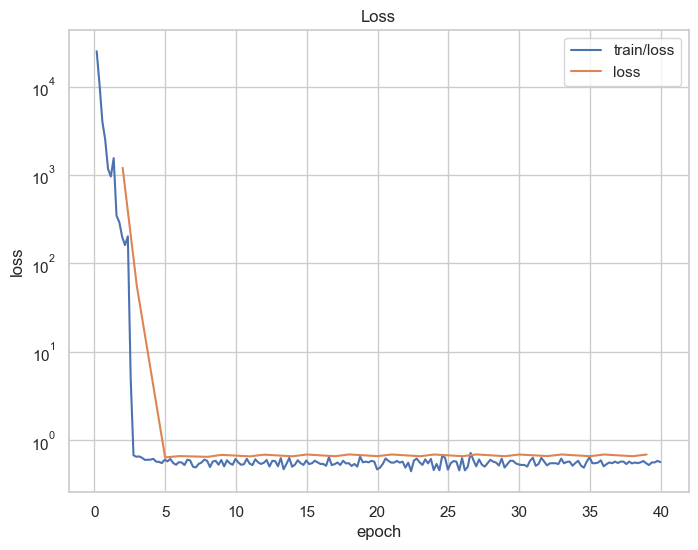

Epochs progress [Loss: 9.019e-02]: 100%|██████████| 40/40 [00:13<00:00,  3.03Epoch/s]


0it [00:00, ?it/s]

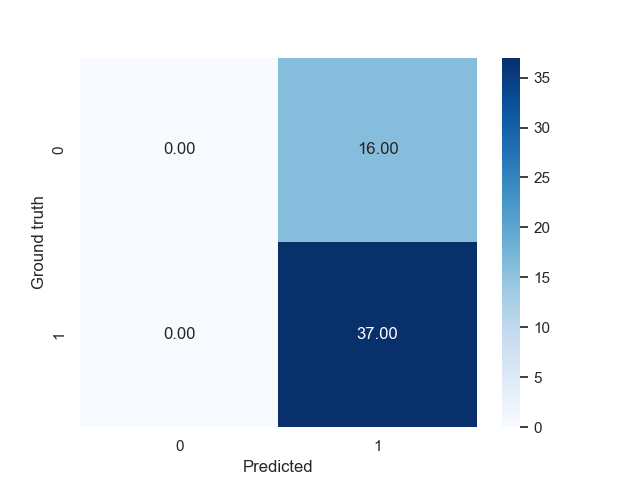

0.698113203048706


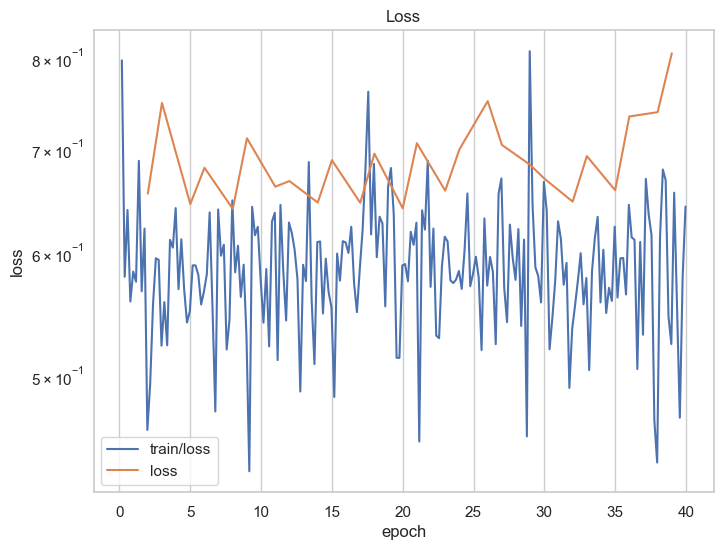

Epochs progress [Loss: 8.658e-02]: 100%|██████████| 40/40 [00:12<00:00,  3.09Epoch/s]


0it [00:00, ?it/s]

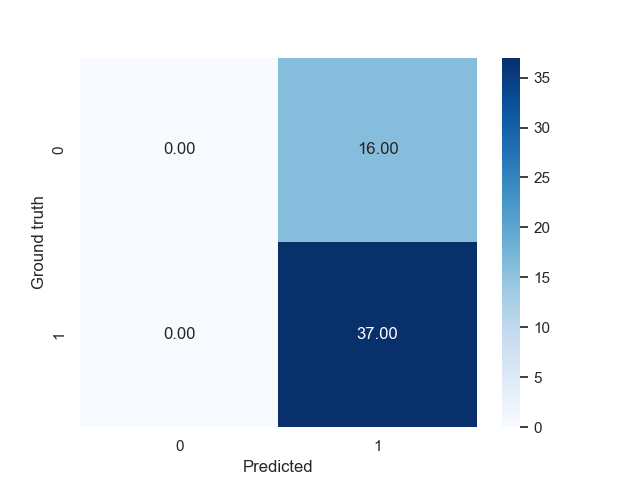

0.698113203048706
######
Iterating over lr: [0.0001, 0.005, 0.01]
#####



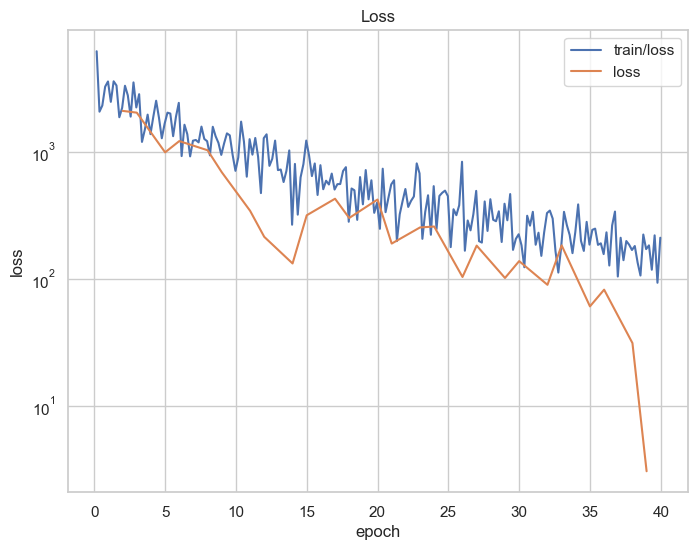

Epochs progress [Loss: 7.510e+00]: 100%|██████████| 40/40 [00:12<00:00,  3.26Epoch/s]


0it [00:00, ?it/s]

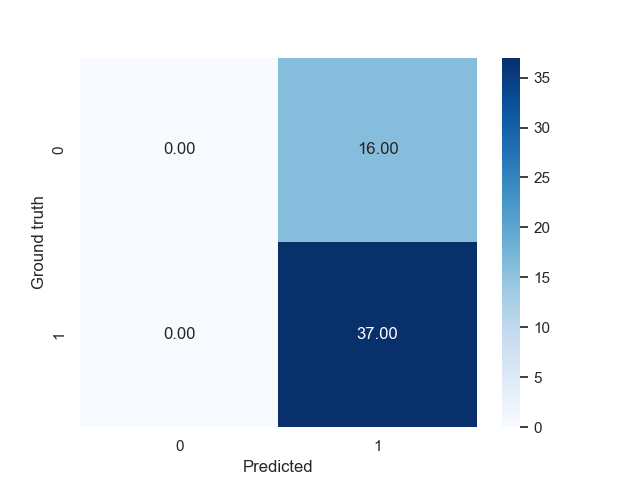

0.698113203048706


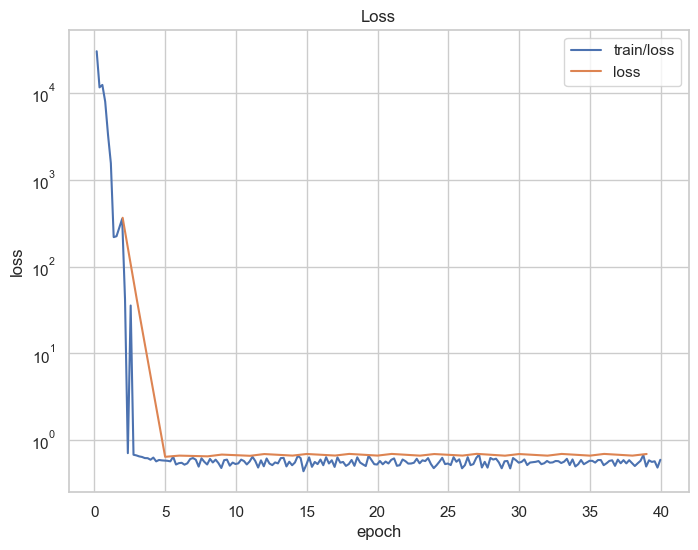

Epochs progress [Loss: 9.024e-02]: 100%|██████████| 40/40 [00:12<00:00,  3.14Epoch/s]


0it [00:00, ?it/s]

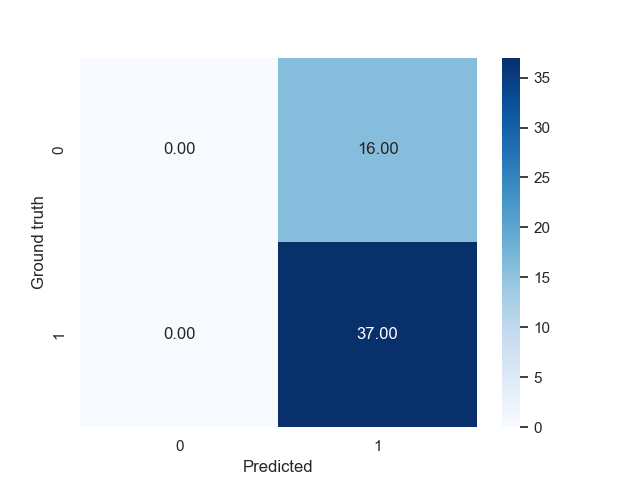

0.698113203048706


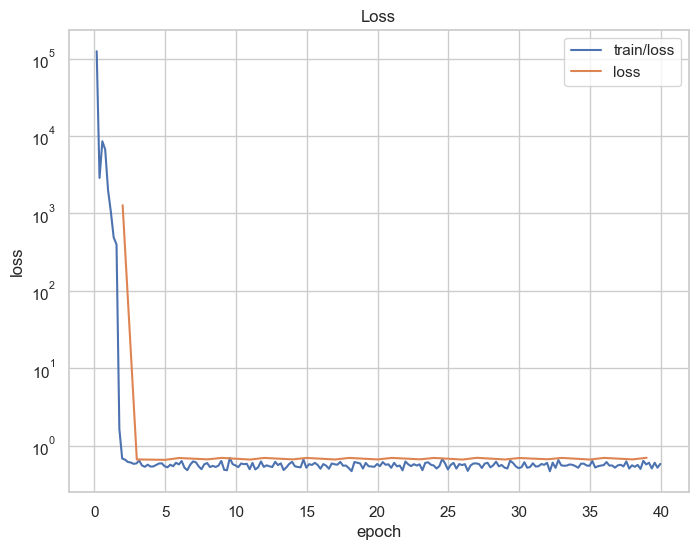

Epochs progress [Loss: 9.026e-02]: 100%|██████████| 40/40 [00:13<00:00,  3.07Epoch/s]


0it [00:00, ?it/s]

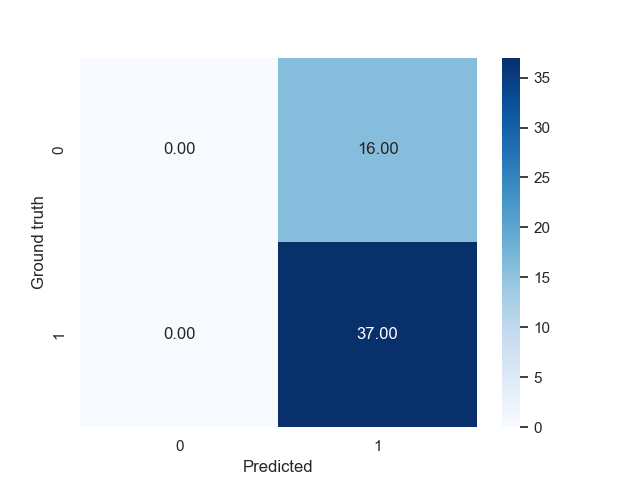

0.698113203048706
######
Iterating over momentum: [True, False]
#####



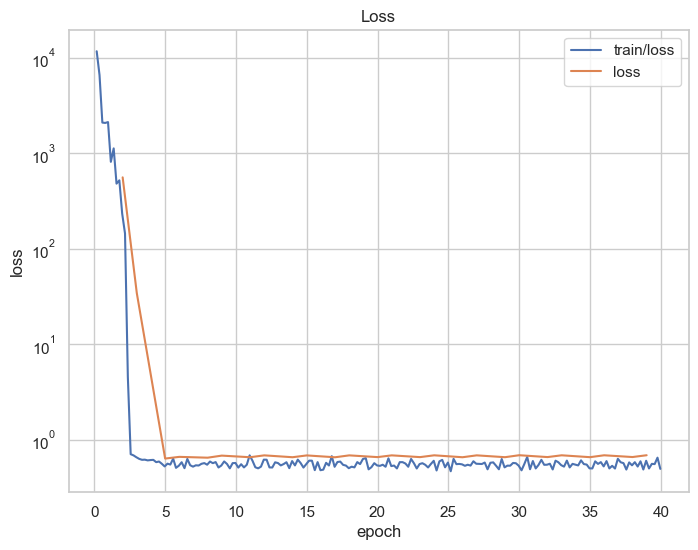

Epochs progress [Loss: 9.020e-02]: 100%|██████████| 40/40 [00:13<00:00,  3.03Epoch/s]


0it [00:00, ?it/s]

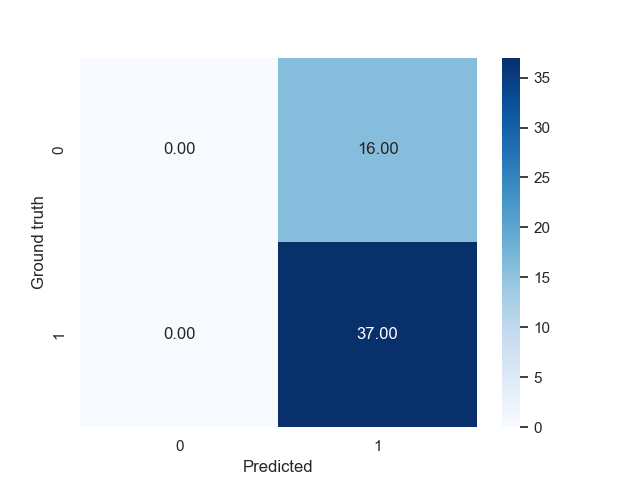

0.698113203048706


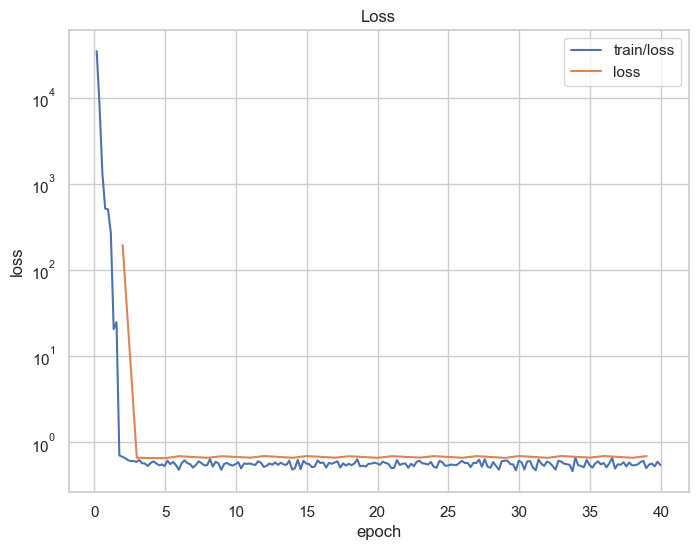

Epochs progress [Loss: 9.031e-02]: 100%|██████████| 40/40 [00:13<00:00,  3.02Epoch/s]


0it [00:00, ?it/s]

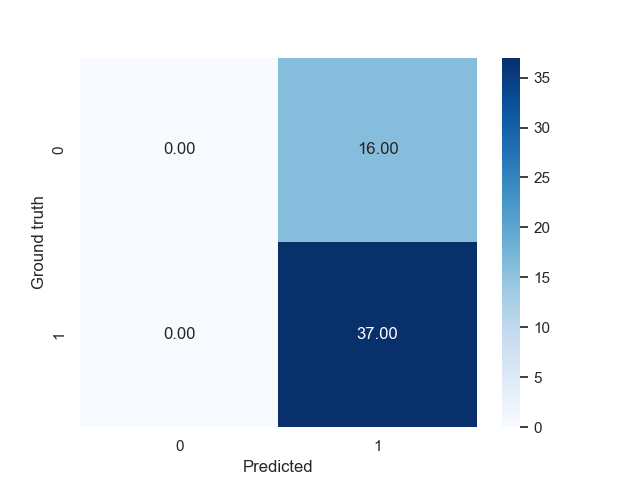

0.698113203048706
######
Iterating over dropout: [0.05, 0.3, 0.6]
#####



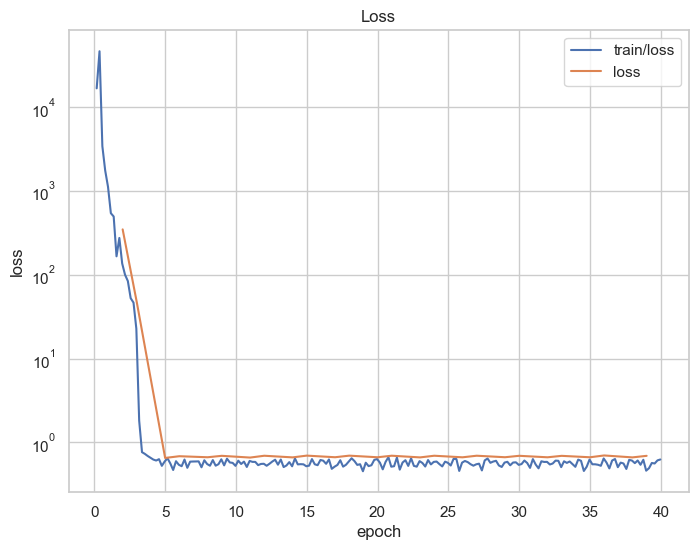

Epochs progress [Loss: 9.062e-02]: 100%|██████████| 40/40 [00:12<00:00,  3.10Epoch/s]


0it [00:00, ?it/s]

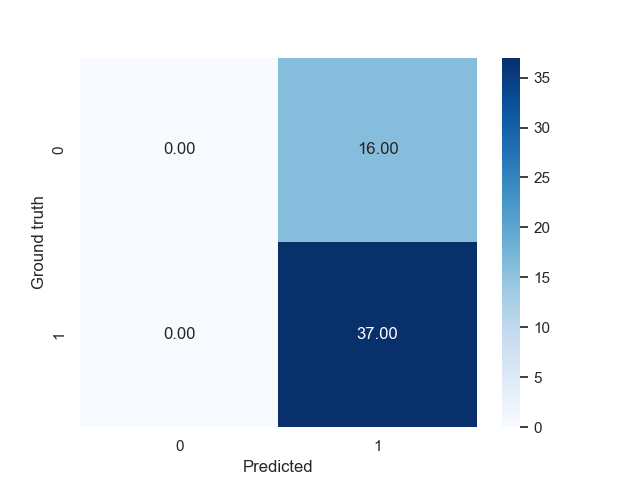

0.698113203048706


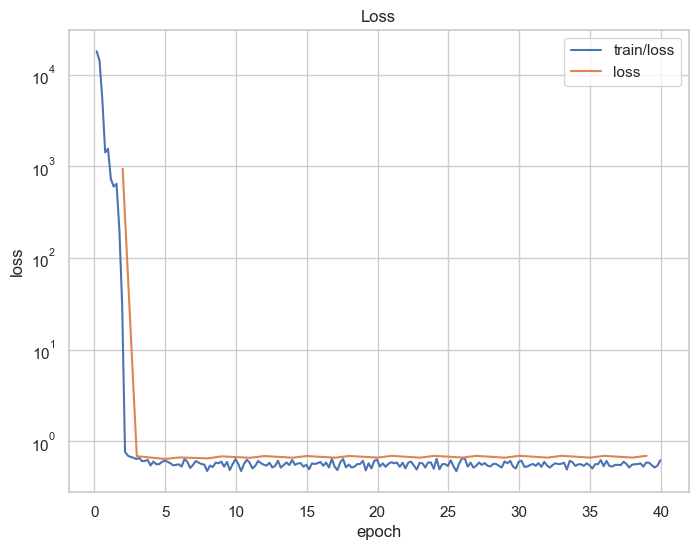

Epochs progress [Loss: 9.044e-02]: 100%|██████████| 40/40 [00:13<00:00,  2.98Epoch/s]


0it [00:00, ?it/s]

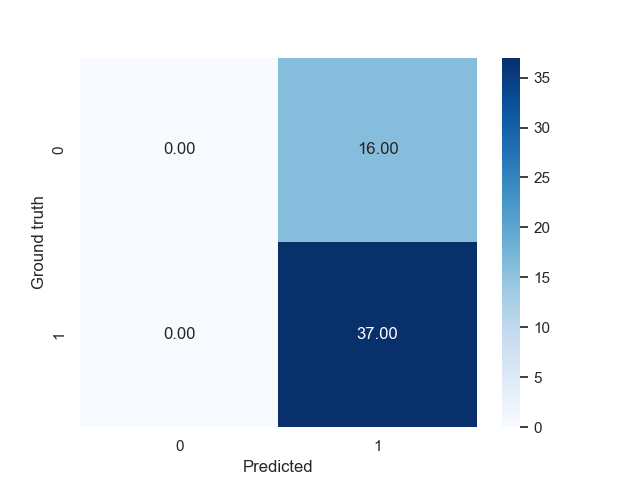

0.698113203048706


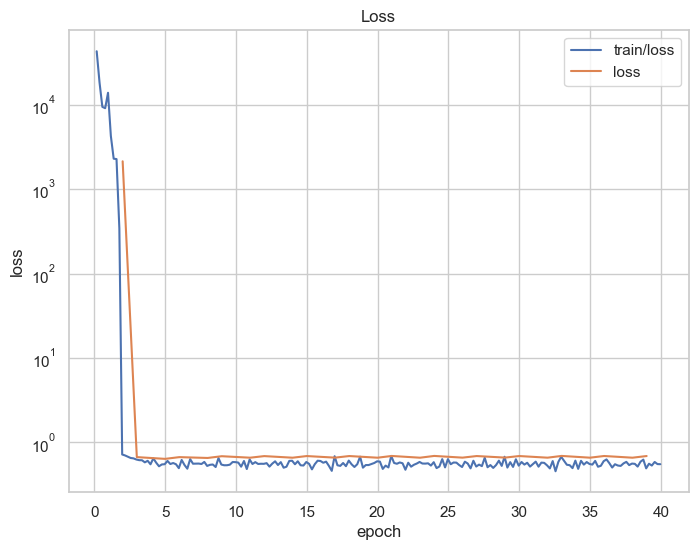

Epochs progress [Loss: 9.040e-02]: 100%|██████████| 40/40 [00:13<00:00,  2.98Epoch/s]


0it [00:00, ?it/s]

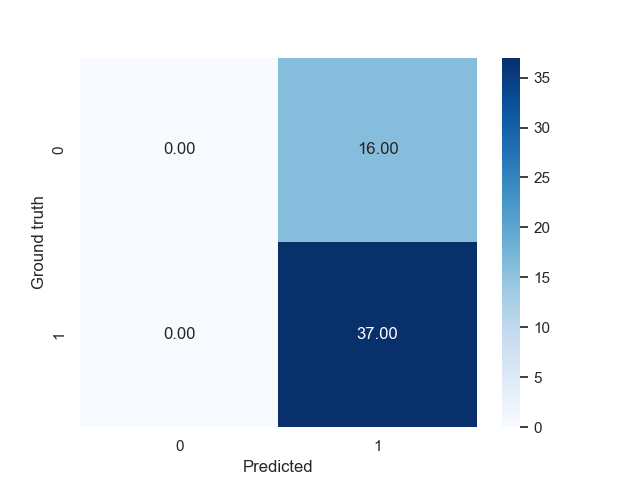

0.698113203048706
######
Iterating over test_dropout: [None, 0.5, 0.8]
#####



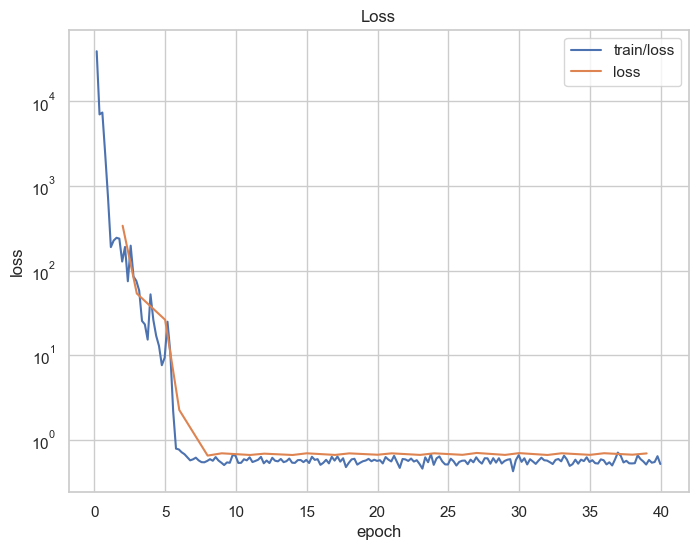

Epochs progress [Loss: 9.008e-02]: 100%|██████████| 40/40 [00:13<00:00,  3.02Epoch/s]


0it [00:00, ?it/s]

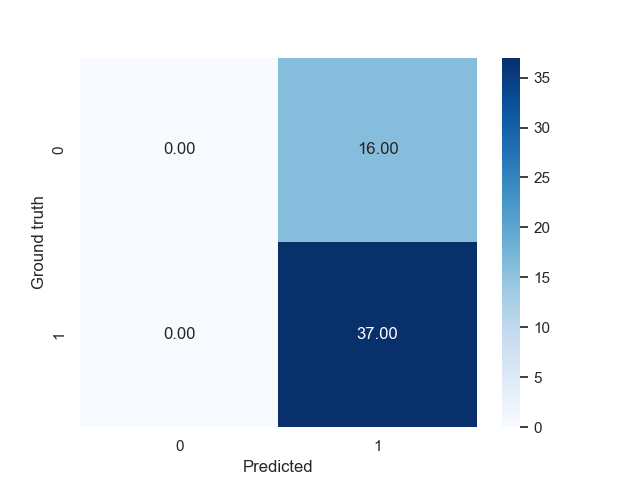

0.698113203048706


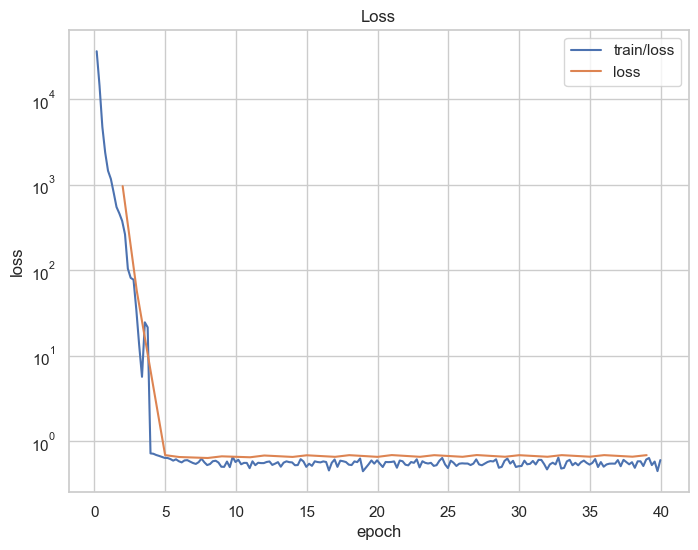

Epochs progress [Loss: 9.013e-02]: 100%|██████████| 40/40 [00:13<00:00,  2.97Epoch/s]


0it [00:00, ?it/s]

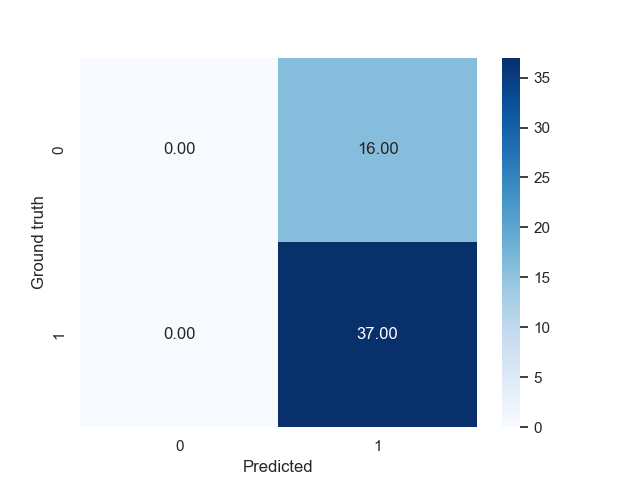

0.698113203048706


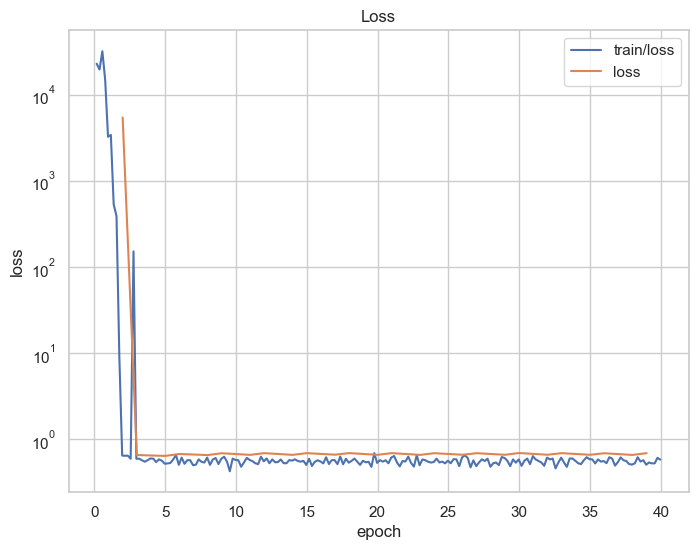

Epochs progress [Loss: 9.066e-02]: 100%|██████████| 40/40 [00:13<00:00,  3.07Epoch/s]


0it [00:00, ?it/s]

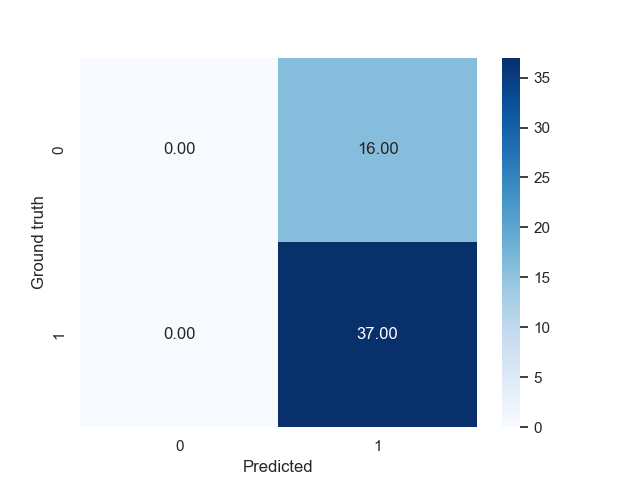

0.698113203048706
######
Iterating over betas: [(0.9, 0.999), (0.0, 0.999)]
#####



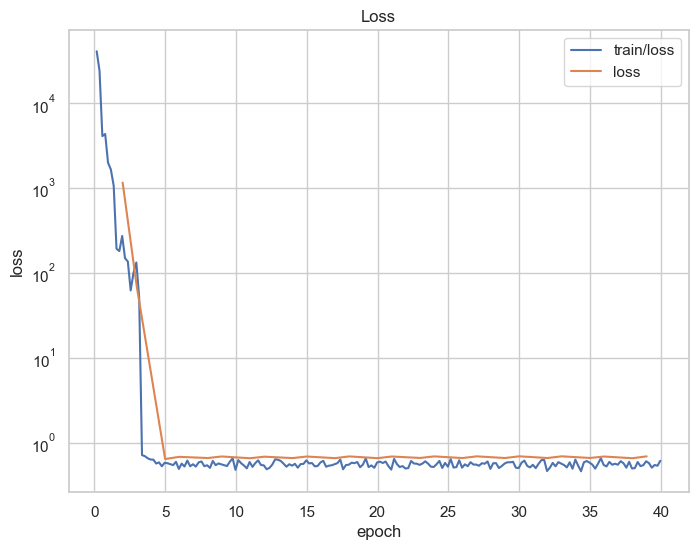

Epochs progress [Loss: 9.049e-02]: 100%|██████████| 40/40 [00:13<00:00,  2.93Epoch/s]


0it [00:00, ?it/s]

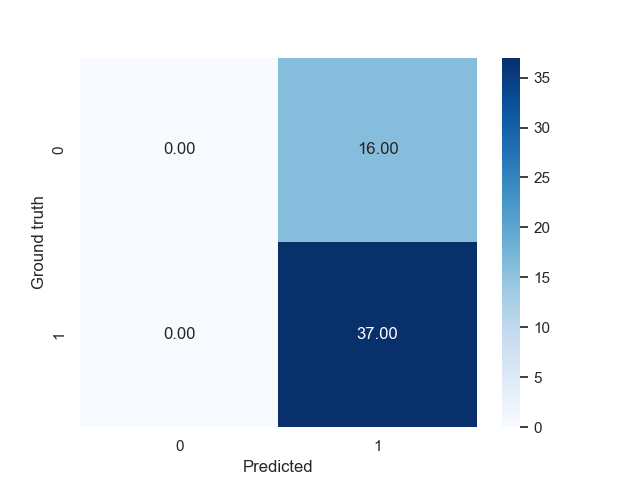

0.698113203048706


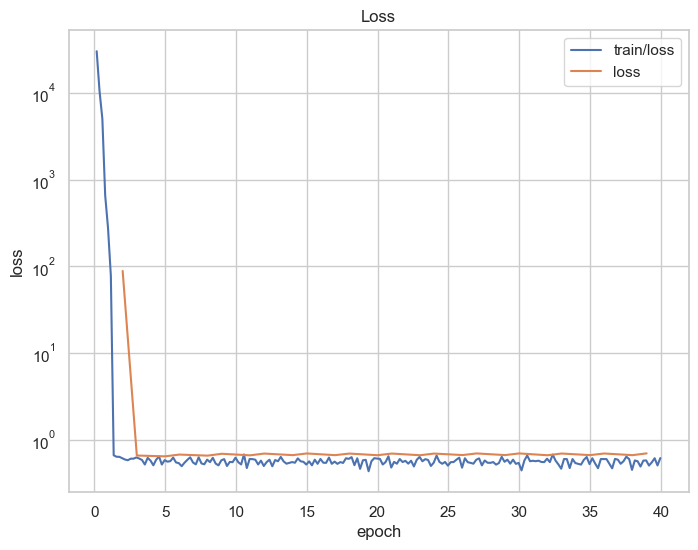

Epochs progress [Loss: 9.038e-02]: 100%|██████████| 40/40 [00:13<00:00,  3.01Epoch/s]


0it [00:00, ?it/s]

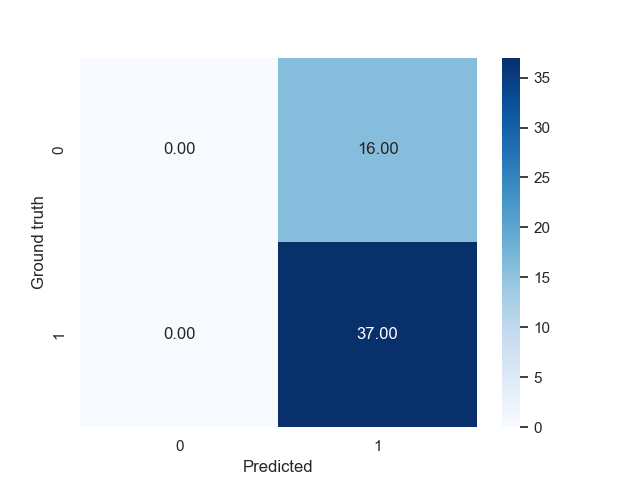

0.698113203048706


In [19]:
# search parameters of MLPClassifier
from models.MLP import *

params.max_epochs = 40
plt.close("all")

params_dict = {
    key: value
    for key, value in grid_params.__dict__.items()
    if not key.startswith("__")
}

best_cparams = {}

# param_combinations = itertools.product(*params_dict.values())
for key in params_dict.keys():
    print(f"######\nIterating over {key}: {params_dict[key]}\n#####\n")
    _best_metric = None
    for val in params_dict[key]:
        cmodel = MLPClassifier(
            MLPConfig.create(
                params,
                n_classes=cdt.classes,
            ).update({key: val})
        )
        ctrainer = Trainer(
            TrainerConfig.create(params, **init_cmetrics(5)).update({key: val})
        )
        ctrainer.fit(cmodel, cdt.loaders())
        metric = eval_cmodel(ctrainer)[0]
        if _best_metric is None or metric < _best_metric:
            _best_metric = metric
            best_cparams[key] = val


In [17]:
# search parameters of MLP

from models.MLP import *

params_dict = {
    key: value
    for key, value in grid_params.__dict__.items()
    if not key.startswith("__")
}

best_params = {}

# param_combinations = itertools.product(*params_dict.values())
for key in params_dict.keys():
    print(f"######\nIterating over {key}: {params_dict[key]}\n#####\n")
    _best_metric = None
    for val in params_dict[key]:
        model = MLP(
            MLPConfig.create(
                params,
            ).update({key: val})
        )
        trainer = Trainer(TrainerConfig.create(params).update({key: val}))
        trainer.fit(model, dt.loaders())
        metric = eval_model(trainer)[0]
        if _best_metric is None or metric < _best_metric:
            _best_metric = metric
            best_params[key] = val


NameError: name 'grid_params' is not defined

In [ ]:
print("Evaluating best params on test set:", best_params)

model = MLPClassifier(
    MLPConfig.create(
        params,
    ).update(best_params)
)
trainer = Trainer(TrainerConfig.create(params).update(best_params))
trainer.fit(model, dt.loaders())
eval_model(trainer, dataloader=dt.test_loader())

print("Evaluating default params on test set:", params)
eval_model(default_trainer, dataloader=dt.test_loader())


In [ ]:
print("Evaluating best cparams on test set:", best_cparams)

cmodel = MLPClassifier(
    MLPConfig.create(
        params,
    ).update(best_cparams)
)
trainer = Trainer(TrainerConfig.create(params).update(best_cparams))
trainer.fit(cmodel, cdt.loaders())
eval_model(trainer, dataloader=dt.test_loader())

print("Evaluating default cparams on test set:", best_cparams)
eval_model(default_ctrainer, dataloader=dt.test_loader())